# sympy Laplace Transforms for solving linear ODEs
> I have found that the Laplace transform  utility in sympy doesn't do what we need for solving linear ODEs.  We've made some needed improvements and included the code in the MATH280 package

- toc: true

In our workflow, we assume sympy as the default, and load the custom-made content from [MATH280 Package](https://github.com/ejbarth/MATH280).

In [1]:
from sympy import *
import MATH280

x = Function("x")
t,s = symbols("t s",real=True,  nonnegative=true )

MATH280


A famously intense pen-and-paper technique from elementary ODEs class:  Laplace Transforms.
Sympy has Laplace capabilities built-in, but with maddening shortcomings.

Let's work with a 2nd order, linear, constant-coefficient, nonhomogeous IVP:
$$ \ddot{x}+3\dot{x}+4x = \sin(2t), \;\;\;\;\;\; x(0)=1, \dot{x}(0)=0$$

In [2]:
ode = Eq(x(t).diff(t,2)+3*x(t).diff(t)+4*x(t) , sin(2*t) )
ode

Eq(4*x(t) + 3*Derivative(x(t), t) + Derivative(x(t), (t, 2)), sin(2*t))

## laplace_transform() in sympy

First let's see how the built-in sympy `laplace_transform()` handles that equation: 

In [3]:
laplace_transform(ode,t,s)

AttributeError: 'Equality' object has no attribute 'as_coeff_mul'

Look at that!  **'Equality' object has no attribute**.  `laplace_transform()` would prefer that we assume the expression we enter is equal to 0:

In [4]:
Lx=laplace_transform(x(t).diff(t,2)+3*x(t).diff(t)+4*x(t) - sin(2*t),t,s)
Lx

(4*LaplaceTransform(x(t), t, s) + 3*LaplaceTransform(Derivative(x(t), t), t, s) + LaplaceTransform(Derivative(x(t), (t, 2)), t, s) - 2/(s**2 + 4),
 0,
 True)

We see the output above is a tuple that includes some conditional statements at the end.  To hide that and see just the transform itself, use the option `noconds=True`

In [5]:
Lx=laplace_transform(x(t).diff(t,2)+3*x(t).diff(t)+4*x(t) - sin(2*t),t,s,noconds=True)
Lx

4*LaplaceTransform(x(t), t, s) + 3*LaplaceTransform(Derivative(x(t), t), t, s) + LaplaceTransform(Derivative(x(t), (t, 2)), t, s) - 2/(s**2 + 4)

### Laplace Transform and Derivatives

Notice in that output another hassle:  `laplace_transform()` ignores the single most useful property of the Laplace Transform:
$$ {\cal L}\{x'(t)\} = s{\cal L}\{x(t)\} - x(0), \mbox{ and } {\cal L}\{x''(t)\} = s^2{\cal L}\{x(t)\} - sx(0)- x'(0).$$

## laplace() in MATH280

We've reworked that and included an alternative `laplace{}` in the [MATH280 Module](https://github.com/ejbarth/MATH280).  

### Solving an equation with Laplace Transforms in four steps:

#### 1. take the transform of everything

In [6]:
L = MATH280.laplace(ode,t,s)
L

Eq(s**2*LaplaceTransform(x(t), t, s) + 3*s*LaplaceTransform(x(t), t, s) - s*x(0) + 4*LaplaceTransform(x(t), t, s) - 3*x(0) - Subs(Derivative(x(t), t), t, 0), 2/(s**2 + 4))

#### 2. plug in the initial conditions

The second step in solving the equation is to plug in the initial conditions:

In [7]:
L0=L.subs(x(0),1).subs(Subs(Derivative(x(t), t), t, 0),0)
L0

Eq(s**2*LaplaceTransform(x(t), t, s) + 3*s*LaplaceTransform(x(t), t, s) - s + 4*LaplaceTransform(x(t), t, s) - 3, 2/(s**2 + 4))

#### 3. solve for the lapace transform of the solution function

The third step is to solve the resulting equation for the symbol ${\cal L}\{x(t)\}$

In [8]:
Lx=solve(L0,LaplaceTransform(x(t),t,s))
Lx

[(s**3 + 3*s**2 + 4*s + 14)/(s**4 + 3*s**3 + 8*s**2 + 12*s + 16)]

#### 4. look up the laplace transform to determine the solution

The fourth and final step is to "look up" that complicated expression in the variable $s$ to determine the function of $t$ with that Laplace transform. The built-in sympy funtion `inverse_laplace_transform()` works fine for that, with the slight annoyance that it doesn't align perfectly with the list format of output from `solve()`.  So I've included in  MATH280 a little wrapper called `laplaceInv()` that extracts the zeroth entry from that list. **I've noticed that this step can run really slowly.**

In [9]:
sol = MATH280.laplaceInv(Lx,s,t)
sol

-cos(2*t)*Heaviside(t)/6 + sqrt(7)*exp(-3*t/2)*sin(sqrt(7)*t/2)*Heaviside(t)/2 + 7*exp(-3*t/2)*cos(sqrt(7)*t/2)*Heaviside(t)/6

Something to notice is that every term as a $\theta(t)$.  That's the unit step function:  $\theta(t)=1$ if $t\gt 0$ and otherwise zero.  Seems to be enforcing the assumption that our solution only makes sense for nonnegative time $t$.

We can plot the solution with sympy plot:

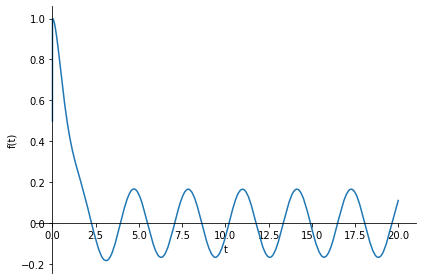

In [10]:
plot(sol,(t,0,20))

And just in case there was any doubt, we notice that `dsolve()` produces the same solution.

In [11]:
dsolve(ode,x(t),ics={x(0):1, x(t).diff(t).subs(t,0):0})

Eq(x(t), (sqrt(7)*sin(sqrt(7)*t/2)/2 + 7*cos(sqrt(7)*t/2)/6)*exp(-3*t/2) - cos(2*t)/6)

## Discontinuous Forcing Functions

We haven't yet explored what I think is *the* reason to consider Laplace Transforms in the first place:  discontinuous forcing functions.  

### A first-order model with a square wave switch function

Suppose we model a capacitor with an external voltage source that switches on at $t=2$ and off at $t=5$.  
The equation, in some idealized units, could be
$$\dot{x} - x = \theta(t-2) - \theta(t-5), \;\;\;\;\;  x(0)=0 $$
where $\theta(t-a)$ is the Heaviside unit step function that turns on at $t=a$.

In [12]:
capmodel = Eq(x(t).diff(t)+x(t), Heaviside(t-2)-Heaviside(t-5))
capmodel

Eq(x(t) + Derivative(x(t), t), -Heaviside(t - 5) + Heaviside(t - 2))

We'll complete the four steps as in the previous example:  

In [13]:
L=MATH280.laplace(capmodel,t,s)
L

Eq(s*LaplaceTransform(x(t), t, s) + LaplaceTransform(x(t), t, s) - x(0), exp(-2*s)/s - exp(-5*s)/s)

In [14]:
L0=L.subs(x(0),0)
L0

Eq(s*LaplaceTransform(x(t), t, s) + LaplaceTransform(x(t), t, s), exp(-2*s)/s - exp(-5*s)/s)

In [15]:
Ls=solve(L0,LaplaceTransform(x(t),t,s))
Ls

[(exp(3*s) - 1)*exp(-5*s)/(s*(s + 1))]

In [16]:
capsol=MATH280.laplaceInv(Ls,s,t)
capsol

-Heaviside(t - 5) + Heaviside(t - 2) + exp(5)*exp(-t)*Heaviside(t - 5) - exp(2)*exp(-t)*Heaviside(t - 2)

The functional form of the solution looks a little opaque, so lets make a plot of the solution together with the right hand side function:

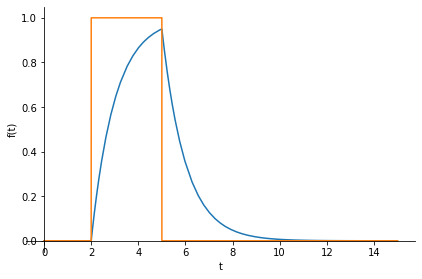

In [17]:
plot(capsol,
     Heaviside(t-2)-Heaviside(t-5),
    (t,0,15),)

### A second-order example with a delta function

Here's an example from the undergraduate ODE textbook by Blanchard, Devaney and Hall:
$$\ddot{x} +2\dot{x}+3x= \delta(t-1)+3\delta(t-4), \;\;\;\;\; x(0)=0, \dot{x}(0)=0$$

In [20]:
ode2 = Eq(x(t).diff(t,2)+2*x(t).diff(t)+3*x(t),DiracDelta(t-1)+3*DiracDelta(t-4))
ode2

Eq(3*x(t) + 2*Derivative(x(t), t) + Derivative(x(t), (t, 2)), 3*DiracDelta(t - 4) + DiracDelta(t - 1))

In [23]:
L=MATH280.laplace(ode2,t,s)
L

Eq(s**2*LaplaceTransform(x(t), t, s) + 2*s*LaplaceTransform(x(t), t, s) - s*x(0) + 3*LaplaceTransform(x(t), t, s) - 2*x(0) - Subs(Derivative(x(t), t), t, 0), exp(-s) + 3*exp(-4*s))

In [26]:
Ls=L.subs(x(0),0).subs(Subs(Derivative(x(t), t), t, 0),0)
Ls

Eq(s**2*LaplaceTransform(x(t), t, s) + 2*s*LaplaceTransform(x(t), t, s) + 3*LaplaceTransform(x(t), t, s), exp(-s) + 3*exp(-4*s))

In [28]:
Lx=solve(Ls,LaplaceTransform(x(t),t,s))
Lx

[(exp(3*s) + 3)*exp(-4*s)/(s**2 + 2*s + 3)]

In [31]:
sol2 = MATH280.laplaceInv(Lx,s,t)
sol2

3*sqrt(2)*exp(4)*exp(-t)*sin(sqrt(2)*t)*cos(4*sqrt(2))*Heaviside(t - 4)/2 + sqrt(2)*E*exp(-t)*sin(sqrt(2)*t - sqrt(2))*Heaviside(t - 1)/2 - 3*sqrt(2)*exp(4)*exp(-t)*sin(4*sqrt(2))*cos(sqrt(2)*t)*Heaviside(t - 4)/2

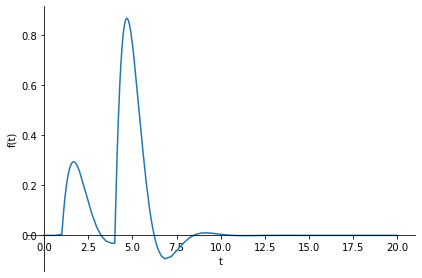

In [32]:
plot(sol2,(t,0,20))

We can see in the plot above how the impulse at $t=1$ and $t=4$ re-energizes the system.